<h1> Resolvable sources Plotter </h1> 

In the following, we'll implement a notebook to plot the distribution in redshift (together with its statistical uncertainties) of the resolvable sources for a _fiducial BBH_ population, together with the redshift distribution of resolvable sources coming from a _PBH_ subpopulation.  
First of all, we need to import some modules ! 

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import os
import IPython
import pandas as pd
import pickle
import multiprocessing as mp
from tqdm import tqdm
import scipy.stats as scst
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.stats import poisson
from scipy.special import gamma, hyp1f1
from multiprocessing import Pool, Manager, Value
from functools import partial
from LISAhdf5 import LISAhdf5,ParsUnits
%matplotlib inline
%run BigFont.py
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

<h2> Loading the datasets </h2> 

The precomputed datasets can be loaded using:

In [2]:
# Loading the fiducial BBH population informations

#file_to_read = open("aplus_FidRedDis.p", "rb")
#Fid_P = pickle.load(file_to_read)

In [3]:
# Loading the fiducial BBH population informations

#file_to_read = open("aplus_SubPopRedDis.p", "rb")
#Sub_P = pickle.load(file_to_read)

In [4]:
Fid_Pop = {}
Sub_Pop = {}

In [5]:
# Here we select which is the user that generated the SNRs

User = 'Paolo'
#User = 'Mauro'

<h2> Loading the populations catalogues </h2> 

To begin, we can load the fiducial population catalogues as:

In [6]:
# Loading the aplus LIGO SNR Dataframes

LIGO_Fid1 = pd.read_pickle(User + 'Results/A+/Fiducial1.pkl')
LIGO_Fid2 = pd.read_pickle(User + 'Results/A+/Fiducial2.pkl')
LIGO_Fid3 = pd.read_pickle(User + 'Results/A+/Fiducial3.pkl')
LIGO_Fid4 = pd.read_pickle(User + 'Results/A+/Fiducial4.pkl')
LIGO_Fid5 = pd.read_pickle(User + 'Results/A+/Fiducial5.pkl')
LIGO_Fid6 = pd.read_pickle(User + 'Results/A+/Fiducial6.pkl')
LIGO_Fid7 = pd.read_pickle(User + 'Results/A+/Fiducial7.pkl')
LIGO_Fid8 = pd.read_pickle(User + 'Results/A+/Fiducial8.pkl')
LIGO_Fid9 = pd.read_pickle(User + 'Results/A+/Fiducial9.pkl')
LIGO_Fid10 = pd.read_pickle(User + 'Results/A+/Fiducial10.pkl')

# Loading the ET SNR Dataframes

ET_Fid1 = pd.read_pickle(User + 'Results/ET/Fiducial1.pkl')
ET_Fid2 = pd.read_pickle(User + 'Results/ET/Fiducial2.pkl')
ET_Fid3 = pd.read_pickle(User + 'Results/ET/Fiducial3.pkl')
ET_Fid4 = pd.read_pickle(User + 'Results/ET/Fiducial4.pkl')
ET_Fid5 = pd.read_pickle(User + 'Results/ET/Fiducial5.pkl')
ET_Fid6 = pd.read_pickle(User + 'Results/ET/Fiducial6.pkl')
ET_Fid7 = pd.read_pickle(User + 'Results/ET/Fiducial7.pkl')
ET_Fid8 = pd.read_pickle(User + 'Results/ET/Fiducial8.pkl')
ET_Fid9 = pd.read_pickle(User + 'Results/ET/Fiducial9.pkl')
ET_Fid10 = pd.read_pickle(User + 'Results/ET/Fiducial10.pkl')

the catalogues appears as follows:

In [7]:
LIGO_Fid1

,Redshift,Mass1,Mass2,InitialFrequency,InBandTime,EclipticLongitude,EclipticLatitude,Inclination,Polarization,InitialPhase,CoalTime,Distance,Spin1,Spin2,AzimuthalAngleOfSpin1,AzimuthalAngleOfSpin2,AnalSNRIMRPD_aplusLIGO
321,0.315189,8.254963,7.997395,0.070966,0.693186,2.457758,0.290737,1.543041,2.367408,0.120457,0.911671,1.695859,0.211864,0.219763,0.726429,0.948634,9.217432
1063,0.248921,8.738862,8.017444,0.082442,0.465911,3.067189,-0.900810,0.876766,0.265954,5.397562,0.581886,1.293607,0.296917,0.549974,0.627486,1.307798,12.362203
1216,0.308894,8.642866,8.491033,0.066438,0.760296,4.494479,-0.442934,2.587163,2.594180,0.869814,0.995146,1.656726,0.173783,0.268617,1.003340,1.965017,9.832018
1334,0.352909,9.425290,8.847322,0.070240,0.570150,0.898230,-0.560426,1.564086,3.778750,5.743589,0.771361,1.934218,0.353620,0.137954,0.809136,0.261427,8.848814
1339,0.358818,10.626760,8.900496,0.076483,0.407740,0.201726,-1.168070,0.768790,2.796431,3.381839,0.554044,1.972151,0.223998,0.074297,1.414465,0.489427,9.099632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79631,1.582953,240.506882,179.543304,0.014059,0.119624,1.388391,0.006244,0.942080,5.830381,5.866235,0.308983,12.026253,0.174453,0.330132,1.171356,2.179946,11.405282
79633,1.838694,263.363586,224.032379,0.027127,0.014506,1.744225,-0.865487,0.267937,5.828754,2.504580,0.041179,14.459171,0.249487,0.207810,0.084108,0.909107,9.700063
79636,1.714291,239.296112,199.057495,0.012239,0.151495,1.890039,1.249909,0.566028,3.871885,4.140324,0.411201,13.266532,0.291898,0.341904,1.514467,1.496648,10.585193
79638,1.252137,215.501923,155.747757,0.010457,0.372941,4.551513,0.477138,2.468452,2.055078,3.156182,0.839915,9.002340,0.504529,0.521859,0.504588,1.043621,14.885737


If the SNRS are generated by Mauro, we have to rename some columns by doing:

In [8]:
# Renaming the columns in the dataframes

if User == 'Mauro':

    LIGO_Fid1.rename(columns = {'redshift':'Redshift'}, inplace = True)
    LIGO_Fid2.rename(columns = {'redshift':'Redshift'}, inplace = True)
    LIGO_Fid3.rename(columns = {'redshift':'Redshift'}, inplace = True)
    LIGO_Fid4.rename(columns = {'redshift':'Redshift'}, inplace = True)
    LIGO_Fid5.rename(columns = {'redshift':'Redshift'}, inplace = True)
    LIGO_Fid6.rename(columns = {'redshift':'Redshift'}, inplace = True)
    LIGO_Fid7.rename(columns = {'redshift':'Redshift'}, inplace = True)
    LIGO_Fid8.rename(columns = {'redshift':'Redshift'}, inplace = True)
    LIGO_Fid9.rename(columns = {'redshift':'Redshift'}, inplace = True)
    LIGO_Fid10.rename(columns = {'redshift':'Redshift'}, inplace = True)

    ET_Fid1.rename(columns = {'redshift':'Redshift'}, inplace = True)
    ET_Fid2.rename(columns = {'redshift':'Redshift'}, inplace = True)
    ET_Fid3.rename(columns = {'redshift':'Redshift'}, inplace = True)
    ET_Fid4.rename(columns = {'redshift':'Redshift'}, inplace = True)
    ET_Fid5.rename(columns = {'redshift':'Redshift'}, inplace = True)
    ET_Fid6.rename(columns = {'redshift':'Redshift'}, inplace = True)
    ET_Fid7.rename(columns = {'redshift':'Redshift'}, inplace = True)
    ET_Fid8.rename(columns = {'redshift':'Redshift'}, inplace = True)
    ET_Fid9.rename(columns = {'redshift':'Redshift'}, inplace = True)
    ET_Fid10.rename(columns = {'redshift':'Redshift'}, inplace = True)

and in order to consider only resolvable sources we can cut them by doing:

In [9]:
if User == 'Mauro':

    #Cutting the non-resolvable events from the A+ LIGO Cats for the fiducial model

    LIGO_Fid1 = LIGO_Fid1[LIGO_Fid1.SNR >= 8.]
    LIGO_Fid2 = LIGO_Fid2[LIGO_Fid2.SNR >= 8.]
    LIGO_Fid3 = LIGO_Fid3[LIGO_Fid3.SNR >= 8.]
    LIGO_Fid4 = LIGO_Fid4[LIGO_Fid4.SNR >= 8.]
    LIGO_Fid5 = LIGO_Fid5[LIGO_Fid5.SNR >= 8.]
    LIGO_Fid6 = LIGO_Fid6[LIGO_Fid6.SNR >= 8.]
    LIGO_Fid7 = LIGO_Fid7[LIGO_Fid7.SNR >= 8.]
    LIGO_Fid8 = LIGO_Fid8[LIGO_Fid8.SNR >= 8.]
    LIGO_Fid9 = LIGO_Fid9[LIGO_Fid9.SNR >= 8.]
    LIGO_Fid10 = LIGO_Fid10[LIGO_Fid10.SNR >= 8.]

    #Cutting the non-resolvable events from the ET Cats for the fiducial model

    ET_Fid1 = ET_Fid1[ET_Fid1.SNR >= 8.]
    ET_Fid2 = ET_Fid2[ET_Fid2.SNR >= 8.]
    ET_Fid3 = ET_Fid3[ET_Fid3.SNR >= 8.]
    ET_Fid4 = ET_Fid4[ET_Fid4.SNR >= 8.]
    ET_Fid5 = ET_Fid5[ET_Fid5.SNR >= 8.]
    ET_Fid6 = ET_Fid6[ET_Fid6.SNR >= 8.]
    ET_Fid7 = ET_Fid7[ET_Fid7.SNR >= 8.]
    ET_Fid8 = ET_Fid8[ET_Fid8.SNR >= 8.]
    ET_Fid9 = ET_Fid9[ET_Fid9.SNR >= 8.]
    ET_Fid10 = ET_Fid10[ET_Fid10.SNR >= 8.]

We can then proceed by loading the subpopulations catalogues:

In [10]:
# Loading the aplus LIGO SNR Dataframes

LIGO_SPop1 = pd.read_pickle(User + 'Results/A+/SubPop1.pkl')
LIGO_SPop2 = pd.read_pickle(User + 'Results/A+/SubPop2.pkl')
LIGO_SPop3 = pd.read_pickle(User + 'Results/A+/SubPop3.pkl')
LIGO_SPop4 = pd.read_pickle(User + 'Results/A+/SubPop4.pkl')
LIGO_SPop5 = pd.read_pickle(User + 'Results/A+/SubPop5.pkl')
LIGO_SPop6 = pd.read_pickle(User + 'Results/A+/SubPop6.pkl')
LIGO_SPop7 = pd.read_pickle(User + 'Results/A+/SubPop7.pkl')
LIGO_SPop8 = pd.read_pickle(User + 'Results/A+/SubPop8.pkl')

# Loading the ET SNR Dataframes

ET_SPop1 = pd.read_pickle(User + 'Results/ET/SubPop1.pkl')
ET_SPop2 = pd.read_pickle(User + 'Results/ET/SubPop2.pkl')
ET_SPop3 = pd.read_pickle(User + 'Results/ET/SubPop3.pkl')
ET_SPop4 = pd.read_pickle(User + 'Results/ET/SubPop4.pkl')
ET_SPop5 = pd.read_pickle(User + 'Results/ET/SubPop5.pkl')
ET_SPop6 = pd.read_pickle(User + 'Results/ET/SubPop6.pkl')
ET_SPop7 = pd.read_pickle(User + 'Results/ET/SubPop7.pkl')
ET_SPop8 = pd.read_pickle(User + 'Results/ET/SubPop8.pkl')

again we have to rename some columns by doing:

In [11]:
# Renaming the columns in the dataframes

if User == 'Mauro':

    LIGO_SPop1.rename(columns = {'redshift':'Redshift'}, inplace = True)
    LIGO_SPop2.rename(columns = {'redshift':'Redshift'}, inplace = True)
    LIGO_SPop3.rename(columns = {'redshift':'Redshift'}, inplace = True)
    LIGO_SPop4.rename(columns = {'redshift':'Redshift'}, inplace = True)
    LIGO_SPop5.rename(columns = {'redshift':'Redshift'}, inplace = True)
    LIGO_SPop6.rename(columns = {'redshift':'Redshift'}, inplace = True)
    LIGO_SPop7.rename(columns = {'redshift':'Redshift'}, inplace = True)
    LIGO_SPop8.rename(columns = {'redshift':'Redshift'}, inplace = True)

    ET_SPop1.rename(columns = {'redshift':'Redshift'}, inplace = True)
    ET_SPop2.rename(columns = {'redshift':'Redshift'}, inplace = True)
    ET_SPop3.rename(columns = {'redshift':'Redshift'}, inplace = True)
    ET_SPop4.rename(columns = {'redshift':'Redshift'}, inplace = True)
    ET_SPop5.rename(columns = {'redshift':'Redshift'}, inplace = True)
    ET_SPop6.rename(columns = {'redshift':'Redshift'}, inplace = True)
    ET_SPop7.rename(columns = {'redshift':'Redshift'}, inplace = True)
    ET_SPop8.rename(columns = {'redshift':'Redshift'}, inplace = True)

and to conclude, consider only the resolvable events by doing:

In [12]:
if User == 'Mauro':

    #Cutting the non-resolvable events from the A+ LIGO Cats for the sub-populations

    LIGO_SPop1 = LIGO_SPop1[LIGO_SPop1.SNR >= 8.]
    LIGO_SPop2 = LIGO_SPop2[LIGO_SPop2.SNR >= 8.]
    LIGO_SPop3 = LIGO_SPop3[LIGO_SPop3.SNR >= 8.]
    LIGO_SPop4 = LIGO_SPop4[LIGO_SPop4.SNR >= 8.]
    LIGO_SPop5 = LIGO_SPop5[LIGO_SPop5.SNR >= 8.]
    LIGO_SPop6 = LIGO_SPop6[LIGO_SPop6.SNR >= 8.]
    LIGO_SPop7 = LIGO_SPop7[LIGO_SPop7.SNR >= 8.]
    LIGO_SPop8 = LIGO_SPop8[LIGO_SPop8.SNR >= 8.]

    #Cutting the non-resolvable events from the ET Cats for the sub-populations

    ET_SPop1 = ET_SPop1[ET_SPop1.SNR >= 8.]
    ET_SPop2 = ET_SPop2[ET_SPop2.SNR >= 8.]
    ET_SPop3 = ET_SPop3[ET_SPop3.SNR >= 8.]
    ET_SPop4 = ET_SPop4[ET_SPop4.SNR >= 8.]
    ET_SPop5 = ET_SPop5[ET_SPop5.SNR >= 8.]
    ET_SPop6 = ET_SPop6[ET_SPop6.SNR >= 8.]
    ET_SPop7 = ET_SPop7[ET_SPop7.SNR >= 8.]
    ET_SPop8 = ET_SPop8[ET_SPop8.SNR >= 8.]

<h2> Building the hystograms with different redshift spacing </h2> 

The hystograms will be built with the following different redshift spacing:

In [13]:
# Linear binning

bin_lin = np.linspace(0.,10.,300) # 0.02 spacing to shows the properties of the redshift distribution of the resolvable sources
bin_mlin = 0.5*(bin_lin[1::] + bin_lin[:-1:])
dbin_lin = (bin_lin[1::] - bin_lin[:-1:])

# Logarithmic binning

bin_log = np.logspace(-2., 1, 60) # approximately 10% error in function of z on each bin, grows with z
bin_mlog = 0.5*(bin_log[1::] + bin_log[:-1:])
dbin_log = (bin_log[1::] - bin_log[:-1:])

simply by saving the output of the matplotlib hystrograms:

<h4> Hystograms for the fiducial populations </h4> 

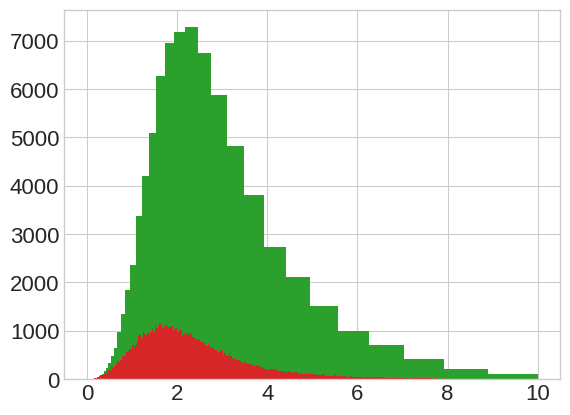

In [14]:
#      THIS IS Fid 1  #



LIGO_vallog, bins, patches = plt.hist(LIGO_Fid1.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_Fid1.Redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_Fid1.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_Fid1.Redshift, bins=bin_lin) # Values for linear binning for LIGO

Fid_Pop['Cat1'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}


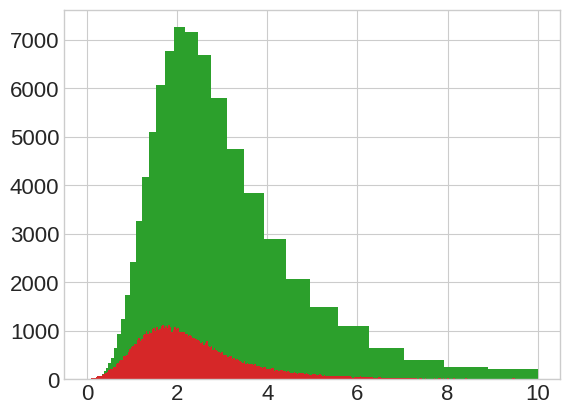

In [15]:
#      THIS IS Fid 2  #

LIGO_vallog, bins, patches = plt.hist(LIGO_Fid2.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_Fid2.Redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_Fid2.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_Fid2.Redshift, bins=bin_lin) # Values for linear binning for LIGO

Fid_Pop['Cat2'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}

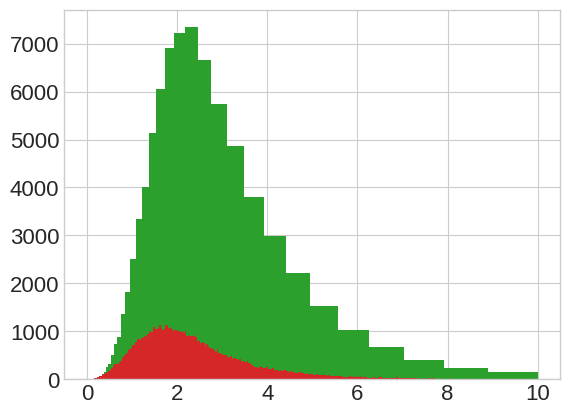

In [16]:
#      THIS IS Fid 3  #

LIGO_vallog, bins, patches = plt.hist(LIGO_Fid3.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_Fid3.Redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_Fid3.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_Fid3.Redshift, bins=bin_lin) # Values for linear binning for LIGO

Fid_Pop['Cat3'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}


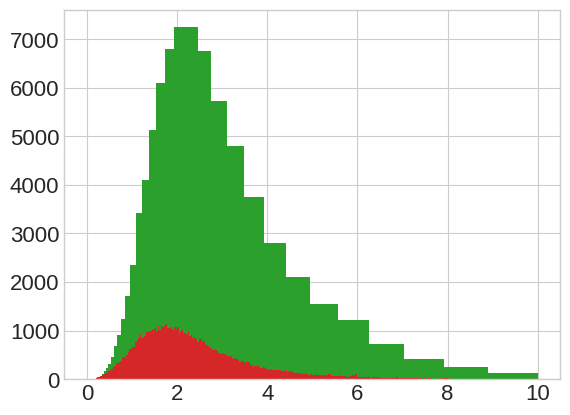

In [17]:
#      THIS IS Fid 4  #

LIGO_vallog, bins, patches = plt.hist(LIGO_Fid4.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_Fid4.Redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_Fid4.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_Fid4.Redshift, bins=bin_lin) # Values for linear binning for LIGO

Fid_Pop['Cat4'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}


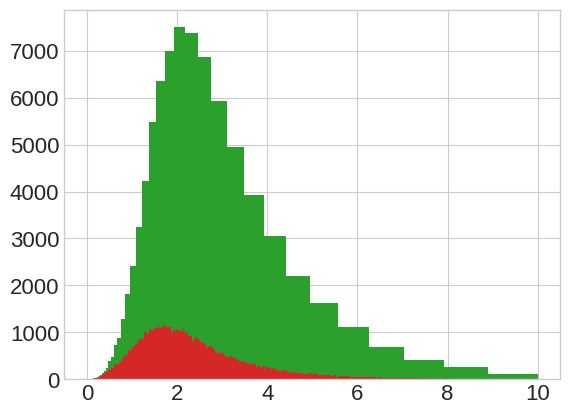

In [18]:
#      THIS IS Fid 5  #

LIGO_vallog, bins, patches = plt.hist(LIGO_Fid5.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_Fid5.Redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_Fid5.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_Fid5.Redshift, bins=bin_lin) # Values for linear binning for LIGO

Fid_Pop['Cat5'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}


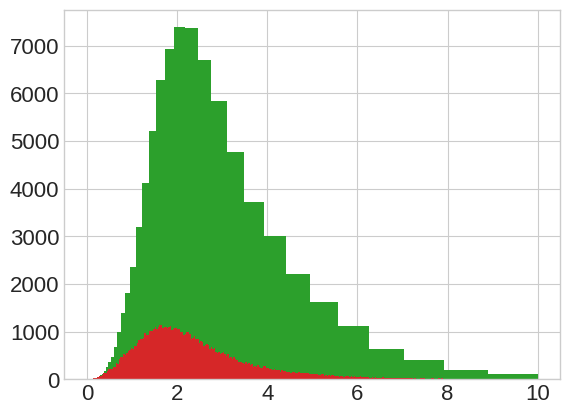

In [19]:
#      THIS IS Fid 6  #

LIGO_vallog, bins, patches = plt.hist(LIGO_Fid6.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_Fid6.Redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_Fid6.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_Fid6.Redshift, bins=bin_lin) # Values for linear binning for LIGO

Fid_Pop['Cat6'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}



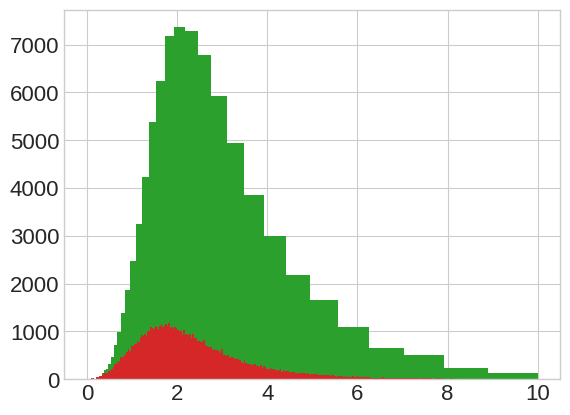

In [20]:
#      THIS IS Fid 7  #

LIGO_vallog, bins, patches = plt.hist(LIGO_Fid7.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_Fid7.Redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_Fid7.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_Fid7.Redshift, bins=bin_lin) # Values for linear binning for LIGO

Fid_Pop['Cat7'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}



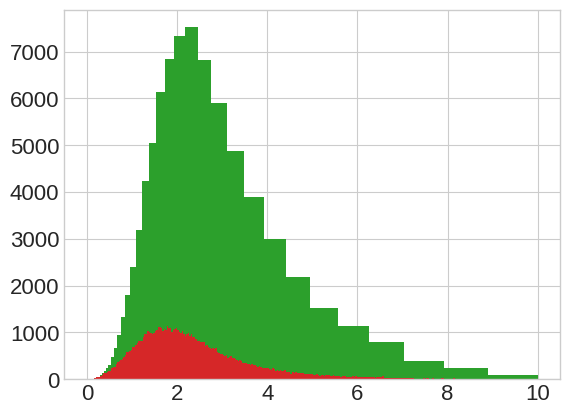

In [21]:
#      THIS IS Fid 8  #

LIGO_vallog, bins, patches = plt.hist(LIGO_Fid8.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_Fid8.Redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_Fid8.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_Fid8.Redshift, bins=bin_lin) # Values for linear binning for LIGO

Fid_Pop['Cat8'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}



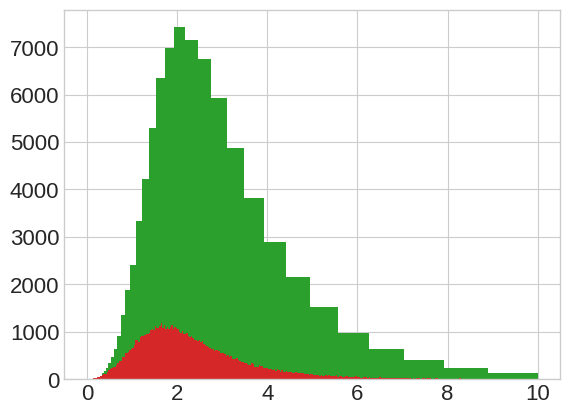

In [22]:
#      THIS IS Fid 9  #

LIGO_vallog, bins, patches = plt.hist(LIGO_Fid9.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_Fid9.Redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_Fid9.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_Fid9.Redshift, bins=bin_lin) # Values for linear binning for LIGO

Fid_Pop['Cat9'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}



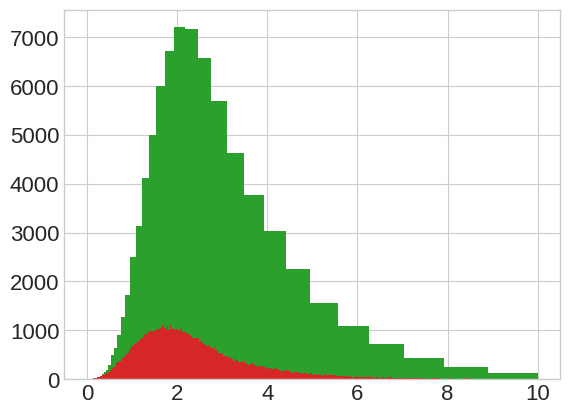

In [23]:
#      THIS IS Fid 10  #

LIGO_vallog, bins, patches = plt.hist(LIGO_Fid10.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_Fid10.Redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_Fid10.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_Fid10.Redshift, bins=bin_lin) # Values for linear binning for LIGO

Fid_Pop['Cat10'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}


<h4> Hystograms for the sub-populations </h4> 

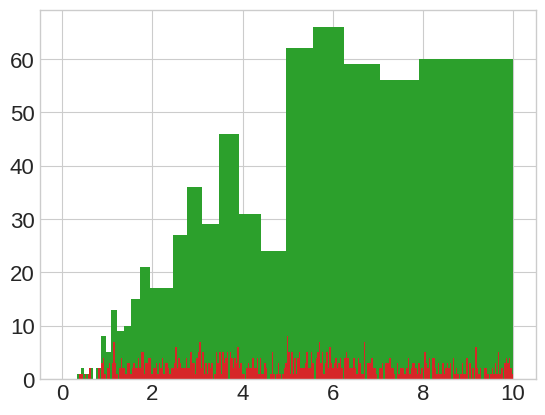

In [24]:
#      THIS IS SubPop 1  #

LIGO_vallog, bins, patches = plt.hist(LIGO_SPop1.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_SPop1.Redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_SPop1.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_SPop1.Redshift, bins=bin_lin) # Values for linear binning for LIGO

Sub_Pop['Point1'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}

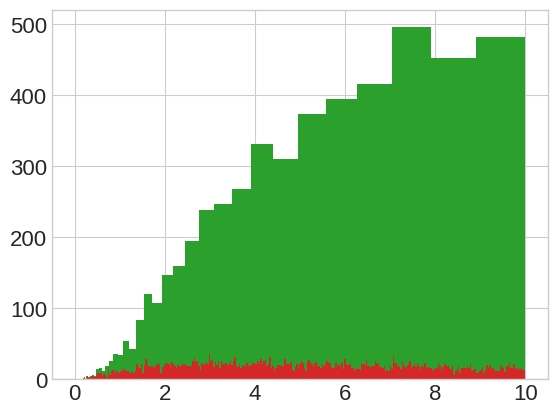

In [25]:
#      THIS IS SubPop 2  #

LIGO_vallog, bins, patches = plt.hist(LIGO_SPop2.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_SPop2.Redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_SPop2.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_SPop2.Redshift, bins=bin_lin) # Values for linear binning for LIGO

Sub_Pop['Point2'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}

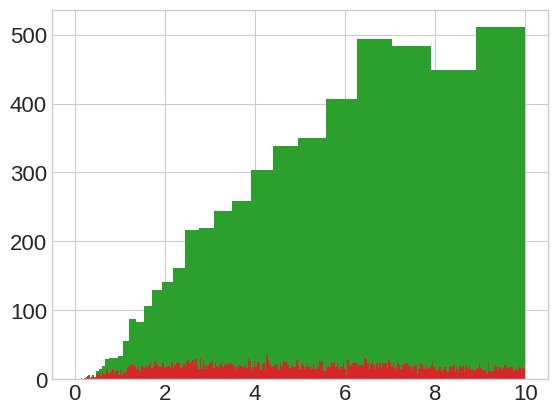

In [26]:
#      THIS IS SubPop 3  #

LIGO_vallog, bins, patches = plt.hist(LIGO_SPop3.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_SPop3.Redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_SPop3.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_SPop3.Redshift, bins=bin_lin) # Values for linear binning for LIGO

Sub_Pop['Point3'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}

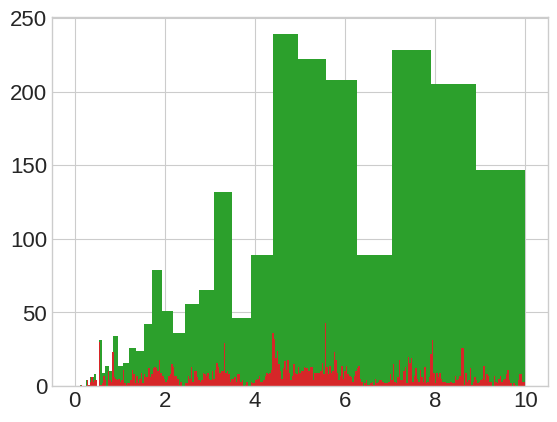

In [27]:
#      THIS IS SubPop 4  #

LIGO_vallog, bins, patches = plt.hist(LIGO_SPop4.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_SPop4.Redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_SPop4.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_SPop4.Redshift, bins=bin_lin) # Values for linear binning for LIGO

Sub_Pop['Point4'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}

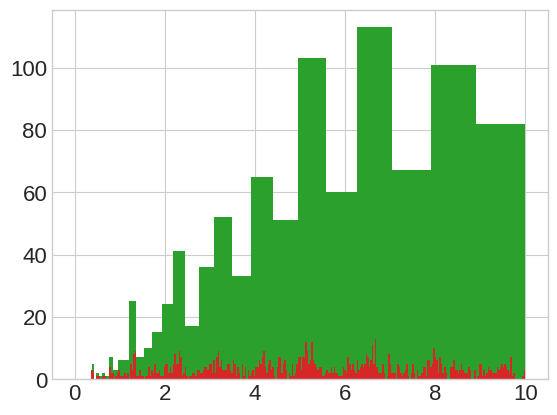

In [28]:
#      THIS IS SubPop 5  #

LIGO_vallog, bins, patches = plt.hist(LIGO_SPop5.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_SPop5.Redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_SPop5.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_SPop5.Redshift, bins=bin_lin) # Values for linear binning for LIGO

Sub_Pop['Point5'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}

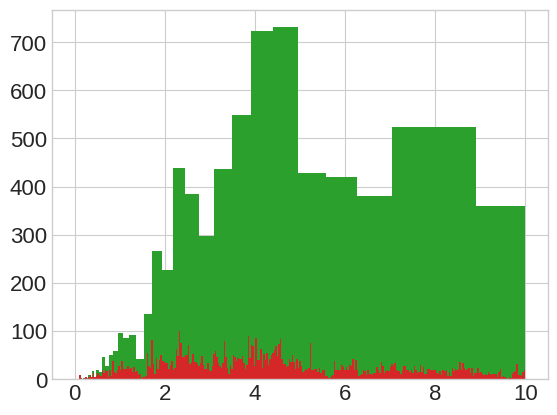

In [29]:
#      THIS IS SubPop 6  #

LIGO_vallog, bins, patches = plt.hist(LIGO_SPop6.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_SPop6.Redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_SPop6.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_SPop6.Redshift, bins=bin_lin) # Values for linear binning for LIGO

Sub_Pop['Point6'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}

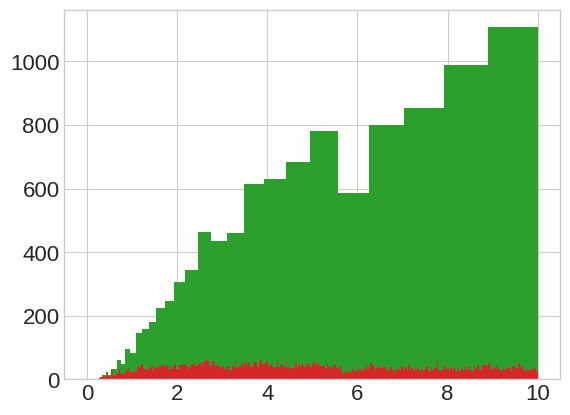

In [30]:
#      THIS IS SubPop 7  #

LIGO_vallog, bins, patches = plt.hist(LIGO_SPop7.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_SPop7.Redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_SPop7.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_SPop7.Redshift, bins=bin_lin) # Values for linear binning for LIGO

Sub_Pop['Point7'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}

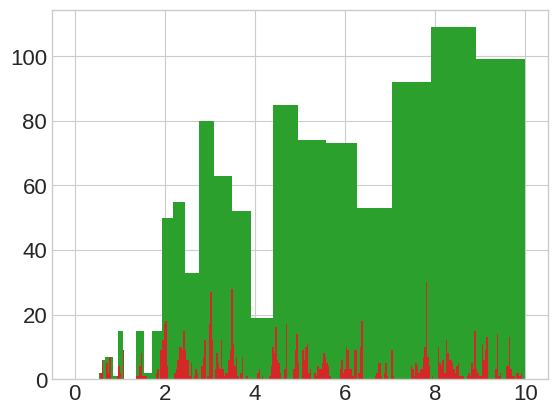

In [31]:
#      THIS IS SubPop 8  #

LIGO_vallog, bins, patches = plt.hist(LIGO_SPop8.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
LIGO_vallin, bins, patches = plt.hist(LIGO_SPop8.Redshift, bins=bin_lin) # Values for linear binning for LIGO

ET_vallog, bins, patches = plt.hist(ET_SPop8.Redshift, bins=bin_log) # Values for logarithmic binning for LIGO
ET_vallin, bins, patches = plt.hist(ET_SPop8.Redshift, bins=bin_lin) # Values for linear binning for LIGO

Sub_Pop['Point8'] = {'Red_lin':{'Redshift': bin_mlin, 'LIGO_ResEvents' : LIGO_vallin/dbin_lin, 'ET_ResEvents' : ET_vallin/dbin_lin}, 'Red_log':{'Redshift': bin_mlog, 'LIGO_ResEvents' : LIGO_vallog/dbin_log, 'ET_ResEvents' : ET_vallog/dbin_log}}

<h2> Statistical analysis of the fiducial population </h2> 

Given the whole set of fiducial population realization, we can obtain some statistical quantities describing the latter as :

In [32]:
# Estimating the average and sigma in each bin for the linear redshift span

N_Cat = 10.

LIGO_avglin = np.linspace(0., 1., len(Fid_Pop['Cat1']['Red_lin']['Redshift']))
LIGO_siglin = np.linspace(0., 1., len(Fid_Pop['Cat1']['Red_lin']['Redshift']))

ET_avglin = np.linspace(0., 1., len(Fid_Pop['Cat1']['Red_lin']['Redshift']))
ET_siglin = np.linspace(0., 1., len(Fid_Pop['Cat1']['Red_lin']['Redshift']))

for i in tqdm(range(len(Fid_Pop['Cat1']['Red_lin']['Redshift']))):
    LIGO_avglin[i] = (1./N_Cat)*(Fid_Pop['Cat1']['Red_lin']['LIGO_ResEvents'][i] + Fid_Pop['Cat2']['Red_lin']['LIGO_ResEvents'][i] + Fid_Pop['Cat3']['Red_lin']['LIGO_ResEvents'][i] + Fid_Pop['Cat4']['Red_lin']['LIGO_ResEvents'][i] + Fid_Pop['Cat5']['Red_lin']['LIGO_ResEvents'][i] + Fid_Pop['Cat6']['Red_lin']['LIGO_ResEvents'][i] + Fid_Pop['Cat7']['Red_lin']['LIGO_ResEvents'][i] + Fid_Pop['Cat8']['Red_lin']['LIGO_ResEvents'][i] + Fid_Pop['Cat9']['Red_lin']['LIGO_ResEvents'][i] + Fid_Pop['Cat10']['Red_lin']['LIGO_ResEvents'][i])
    LIGO_siglin[i] =  np.sqrt((1./(N_Cat - 1))*((Fid_Pop['Cat1']['Red_lin']['LIGO_ResEvents'][i] - LIGO_avglin[i])**2. + (Fid_Pop['Cat2']['Red_lin']['LIGO_ResEvents'][i] - LIGO_avglin[i])**2. + (Fid_Pop['Cat3']['Red_lin']['LIGO_ResEvents'][i] - LIGO_avglin[i])**2. + (Fid_Pop['Cat4']['Red_lin']['LIGO_ResEvents'][i] - LIGO_avglin[i])**2. + (Fid_Pop['Cat5']['Red_lin']['LIGO_ResEvents'][i] - LIGO_avglin[i])**2. + (Fid_Pop['Cat6']['Red_lin']['LIGO_ResEvents'][i] - LIGO_avglin[i])**2. + (Fid_Pop['Cat7']['Red_lin']['LIGO_ResEvents'][i] - LIGO_avglin[i])**2. + (Fid_Pop['Cat8']['Red_lin']['LIGO_ResEvents'][i] - LIGO_avglin[i])**2. + (Fid_Pop['Cat9']['Red_lin']['LIGO_ResEvents'][i] - LIGO_avglin[i])**2. + (Fid_Pop['Cat10']['Red_lin']['LIGO_ResEvents'][i] - LIGO_avglin[i])**2.))
    
    ET_avglin[i] = (1./N_Cat)*(Fid_Pop['Cat1']['Red_lin']['ET_ResEvents'][i] + Fid_Pop['Cat2']['Red_lin']['ET_ResEvents'][i] + Fid_Pop['Cat3']['Red_lin']['ET_ResEvents'][i] + Fid_Pop['Cat4']['Red_lin']['ET_ResEvents'][i] + Fid_Pop['Cat5']['Red_lin']['ET_ResEvents'][i] + Fid_Pop['Cat6']['Red_lin']['ET_ResEvents'][i] + Fid_Pop['Cat7']['Red_lin']['ET_ResEvents'][i] + Fid_Pop['Cat8']['Red_lin']['ET_ResEvents'][i] + Fid_Pop['Cat9']['Red_lin']['ET_ResEvents'][i] + Fid_Pop['Cat10']['Red_lin']['ET_ResEvents'][i])
    ET_siglin[i] =  np.sqrt((1./(N_Cat - 1))*((Fid_Pop['Cat1']['Red_lin']['ET_ResEvents'][i] - ET_avglin[i])**2. + (Fid_Pop['Cat2']['Red_lin']['ET_ResEvents'][i] - ET_avglin[i])**2. + (Fid_Pop['Cat3']['Red_lin']['ET_ResEvents'][i] - ET_avglin[i])**2. + (Fid_Pop['Cat4']['Red_lin']['ET_ResEvents'][i] - ET_avglin[i])**2. + (Fid_Pop['Cat5']['Red_lin']['ET_ResEvents'][i] - ET_avglin[i])**2. + (Fid_Pop['Cat6']['Red_lin']['ET_ResEvents'][i] - ET_avglin[i])**2. + (Fid_Pop['Cat7']['Red_lin']['ET_ResEvents'][i] - ET_avglin[i])**2. + (Fid_Pop['Cat8']['Red_lin']['ET_ResEvents'][i] - ET_avglin[i])**2. + (Fid_Pop['Cat9']['Red_lin']['ET_ResEvents'][i] - ET_avglin[i])**2. + (Fid_Pop['Cat10']['Red_lin']['ET_ResEvents'][i] - ET_avglin[i])**2.))

100%|██████████████████████████████████████| 299/299 [00:00<00:00, 74884.87it/s]


In [33]:
# Estimating the average and sigma in each bin for the logarithmic redshift span

N_Cat = 10.

LIGO_avglog = np.linspace(0., 1., len(Fid_Pop['Cat1']['Red_log']['Redshift']))
LIGO_siglog = np.linspace(0., 1., len(Fid_Pop['Cat1']['Red_log']['Redshift']))

ET_avglog = np.linspace(0., 1., len(Fid_Pop['Cat1']['Red_log']['Redshift']))
ET_siglog = np.linspace(0., 1., len(Fid_Pop['Cat1']['Red_log']['Redshift']))

for i in tqdm(range(len(Fid_Pop['Cat1']['Red_log']['Redshift']))):
    LIGO_avglog[i] = (1./N_Cat)*(Fid_Pop['Cat1']['Red_log']['LIGO_ResEvents'][i] + Fid_Pop['Cat2']['Red_log']['LIGO_ResEvents'][i] + Fid_Pop['Cat3']['Red_log']['LIGO_ResEvents'][i] + Fid_Pop['Cat4']['Red_log']['LIGO_ResEvents'][i] + Fid_Pop['Cat5']['Red_log']['LIGO_ResEvents'][i] + Fid_Pop['Cat6']['Red_log']['LIGO_ResEvents'][i] + Fid_Pop['Cat7']['Red_log']['LIGO_ResEvents'][i] + Fid_Pop['Cat8']['Red_log']['LIGO_ResEvents'][i] + Fid_Pop['Cat9']['Red_log']['LIGO_ResEvents'][i] + Fid_Pop['Cat10']['Red_log']['LIGO_ResEvents'][i])
    LIGO_siglog[i] =  np.sqrt((1./(N_Cat - 1))*((Fid_Pop['Cat1']['Red_log']['LIGO_ResEvents'][i] - LIGO_avglog[i])**2. + (Fid_Pop['Cat2']['Red_log']['LIGO_ResEvents'][i] - LIGO_avglog[i])**2. + (Fid_Pop['Cat3']['Red_log']['LIGO_ResEvents'][i] - LIGO_avglog[i])**2. + (Fid_Pop['Cat4']['Red_log']['LIGO_ResEvents'][i] - LIGO_avglog[i])**2. + (Fid_Pop['Cat5']['Red_log']['LIGO_ResEvents'][i] - LIGO_avglog[i])**2. + (Fid_Pop['Cat6']['Red_log']['LIGO_ResEvents'][i] - LIGO_avglog[i])**2. + (Fid_Pop['Cat7']['Red_log']['LIGO_ResEvents'][i] - LIGO_avglog[i])**2. + (Fid_Pop['Cat8']['Red_log']['LIGO_ResEvents'][i] - LIGO_avglog[i])**2. + (Fid_Pop['Cat9']['Red_log']['LIGO_ResEvents'][i] - LIGO_avglog[i])**2. + (Fid_Pop['Cat10']['Red_log']['LIGO_ResEvents'][i] - LIGO_avglog[i])**2.))
    
    ET_avglog[i] = (1./N_Cat)*(Fid_Pop['Cat1']['Red_log']['ET_ResEvents'][i] + Fid_Pop['Cat2']['Red_log']['ET_ResEvents'][i] + Fid_Pop['Cat3']['Red_log']['ET_ResEvents'][i] + Fid_Pop['Cat4']['Red_log']['ET_ResEvents'][i] + Fid_Pop['Cat5']['Red_log']['ET_ResEvents'][i] + Fid_Pop['Cat6']['Red_log']['ET_ResEvents'][i] + Fid_Pop['Cat7']['Red_log']['ET_ResEvents'][i] + Fid_Pop['Cat8']['Red_log']['ET_ResEvents'][i] + Fid_Pop['Cat9']['Red_log']['ET_ResEvents'][i] + Fid_Pop['Cat10']['Red_log']['ET_ResEvents'][i])
    ET_siglog[i] =  np.sqrt((1./(N_Cat - 1))*((Fid_Pop['Cat1']['Red_log']['ET_ResEvents'][i] - ET_avglog[i])**2. + (Fid_Pop['Cat2']['Red_log']['ET_ResEvents'][i] - ET_avglog[i])**2. + (Fid_Pop['Cat3']['Red_log']['ET_ResEvents'][i] - ET_avglog[i])**2. + (Fid_Pop['Cat4']['Red_log']['ET_ResEvents'][i] - ET_avglog[i])**2. + (Fid_Pop['Cat5']['Red_log']['ET_ResEvents'][i] - ET_avglog[i])**2. + (Fid_Pop['Cat6']['Red_log']['ET_ResEvents'][i] - ET_avglog[i])**2. + (Fid_Pop['Cat7']['Red_log']['ET_ResEvents'][i] - ET_avglog[i])**2. + (Fid_Pop['Cat8']['Red_log']['ET_ResEvents'][i] - ET_avglog[i])**2. + (Fid_Pop['Cat9']['Red_log']['ET_ResEvents'][i] - ET_avglog[i])**2. + (Fid_Pop['Cat10']['Red_log']['ET_ResEvents'][i] - ET_avglog[i])**2.))


100%|████████████████████████████████████████| 59/59 [00:00<00:00, 81671.27it/s]


we can save the statistical results and proceed to plot :

In [34]:
Fid_Pop['apLIGO_StatAnal'] = {'Red_lin':{'Redshift': bin_mlin, 'Avg': LIGO_avglin, 'Sigma' : LIGO_siglin, 'SigP1' : LIGO_avglin + LIGO_siglin, 'SigM1' : LIGO_avglin - LIGO_siglin, 'SigP3' : LIGO_avglin + 3.*LIGO_siglin , 'SigM3' : LIGO_avglin - 3.*LIGO_siglin}, 'Red_log':{'Redshift': bin_mlog, 'Avg': LIGO_avglog, 'Sigma' : LIGO_siglog, 'SigP1' : LIGO_avglog + LIGO_siglog, 'SigM1' : LIGO_avglog - LIGO_siglog, 'SigP3' : LIGO_avglog + 3.*LIGO_siglog , 'SigM3' : LIGO_avglog - 3.*LIGO_siglog}}
Fid_Pop['ET_StatAnal'] = {'Red_lin':{'Redshift': bin_mlin, 'Avg': ET_avglin, 'Sigma' : ET_siglin, 'SigP1' : ET_avglin + ET_siglin, 'SigM1' : ET_avglin - ET_siglin, 'SigP3' : ET_avglin + 3.*ET_siglin , 'SigM3' : ET_avglin - 3.*ET_siglin}, 'Red_log':{'Redshift': bin_mlog, 'Avg': ET_avglog, 'Sigma' : ET_siglog, 'SigP1' : ET_avglog + ET_siglog, 'SigM1' : ET_avglog - ET_siglog, 'SigP3' : ET_avglog + 3.*ET_siglog , 'SigM3' : ET_avglog - 3.*ET_siglog}}

<h2> Plotting the redshift distribution of the resolvable sources </h2> 

Now that we have all the data, we can plot the resolvable sources distribution by running:

<h2> Plotting the results for aplus LIGO </h2>

<h3> Plotting the statistic of the fiducial model </h3> 

<h4> Plotting with the logarithmic scale </h4> 

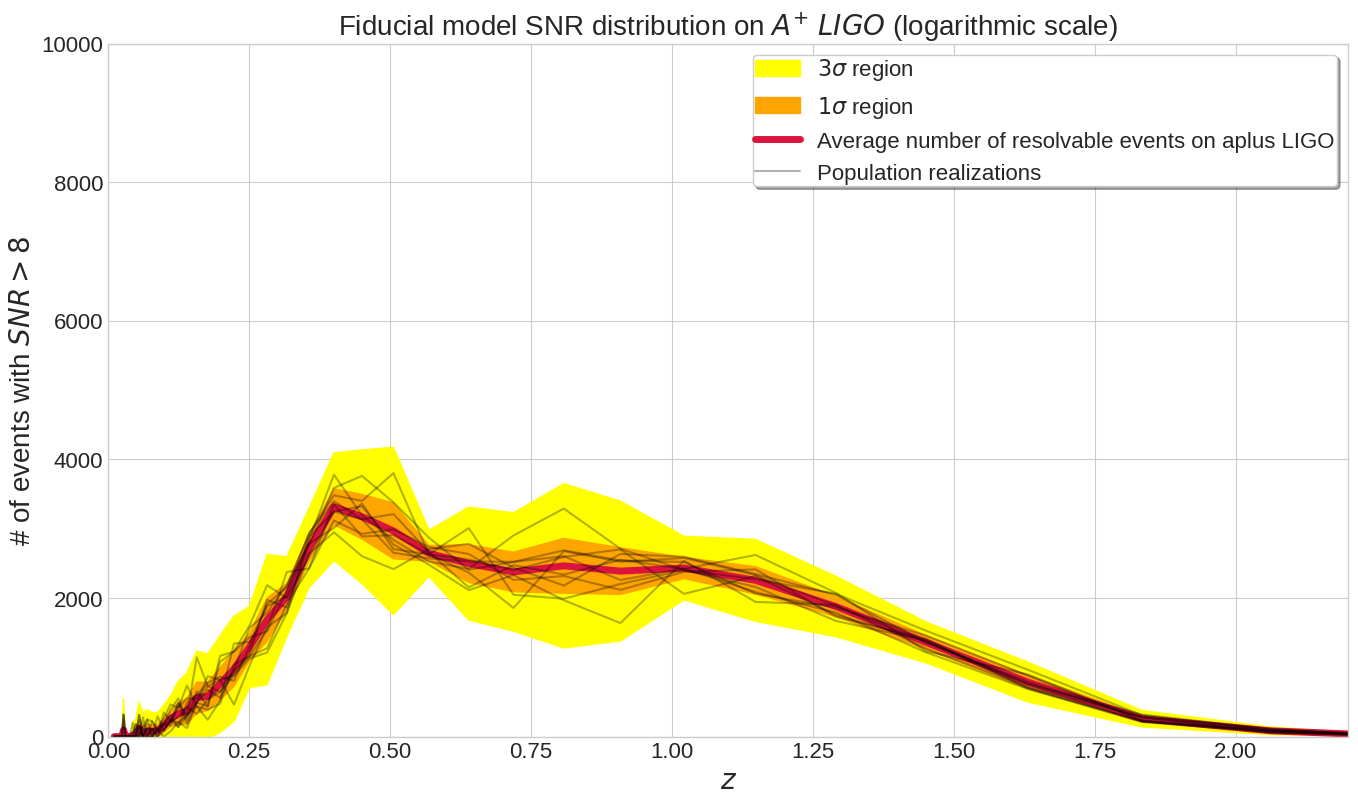

In [35]:
# Plotting the obtained statistics for the fiducial model

plt.figure(figsize=(16,9))
plt.fill_between(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigP3'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigM3'], color = 'yellow', label = r'$3\sigma$ region')
plt.fill_between(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigP1'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigM1'], color = 'orange', label = r'$1\sigma$ region')
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'], color = 'crimson', linewidth=5, label = 'Average number of resolvable events on aplus LIGO')
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat1']['Red_log']['LIGO_ResEvents'], color = 'black', alpha = 0.3, label = 'Population realizations')
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat2']['Red_log']['LIGO_ResEvents'], color = 'black', alpha = 0.3)
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat3']['Red_log']['LIGO_ResEvents'], color = 'black', alpha = 0.3)
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat4']['Red_log']['LIGO_ResEvents'], color = 'black', alpha = 0.3)
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat5']['Red_log']['LIGO_ResEvents'], color = 'black', alpha = 0.3)
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat6']['Red_log']['LIGO_ResEvents'], color = 'black', alpha = 0.3)
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat7']['Red_log']['LIGO_ResEvents'], color = 'black', alpha = 0.3)
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat8']['Red_log']['LIGO_ResEvents'], color = 'black', alpha = 0.3)
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat9']['Red_log']['LIGO_ResEvents'], color = 'black', alpha = 0.3)
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat10']['Red_log']['LIGO_ResEvents'], color = 'black', alpha = 0.3)
plt.xlabel('$z$', fontsize = 20 )
plt.xlim(0.0, 2.2)
plt.ylim(0.,10000.)
plt.legend(loc = 1, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 16})
plt.ylabel('# of events with $SNR > 8$', fontsize = 20)
plt.title(r'Fiducial model SNR distribution on $A^{+} \; LIGO$ (logarithmic scale)',fontsize = 20)
plt.savefig('apLIGOSNRB8EventDistLogBinFidMod.png',dpi=200)

<h3> Plotting the main plus sub-population on APlus LIGO </h3>

<h4> Plotting with the logarithmic scale </h4> 

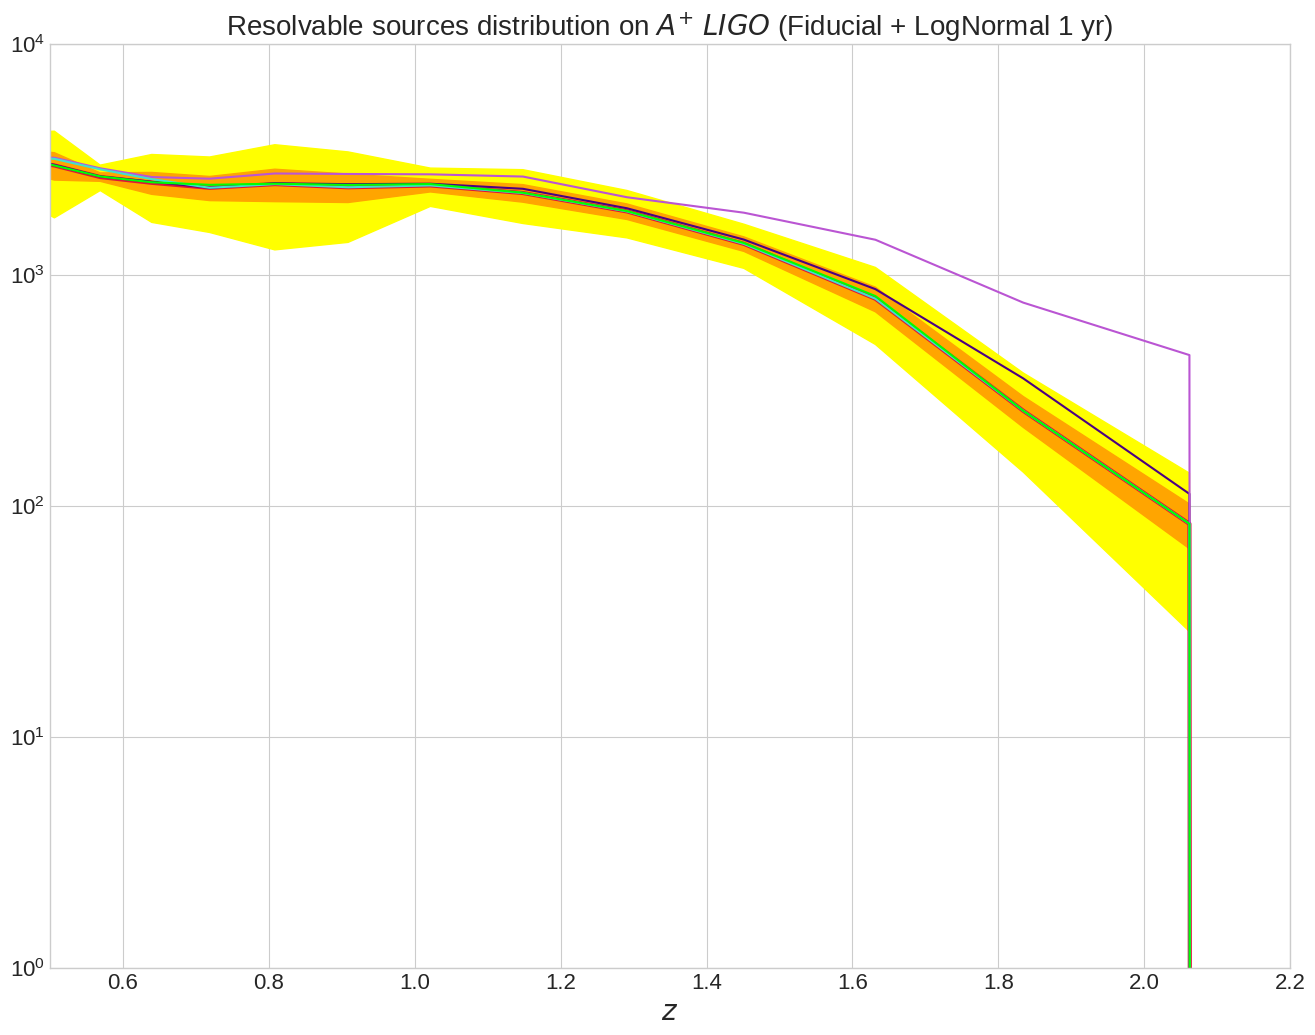

In [36]:
# Plotting the results for the LogNormal subpopulation

plt.figure(figsize=(16,12))
plt.fill_between(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigP3'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigM3'], color = 'yellow', label = r'$3\sigma^{Fid}_{Res}$ region')
plt.fill_between(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigP1'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigM1'], color = 'orange', label = r'$1\sigma^{Fid}_{Res}$ region')
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'], color = 'crimson', linewidth=3, label = 'Fiducial population average number of resolvable events on $A^+$ LIGO')
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point1']['Red_log']['LIGO_ResEvents'], color = 'Indigo', label = 'Avg + Log-Normal Point 1')
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point2']['Red_log']['LIGO_ResEvents'], color = 'mediumorchid', label = 'Avg + Log-Normal Point 2')
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point3']['Red_log']['LIGO_ResEvents'], color = 'turquoise', label = 'Avg + Log-Normal Point 3')
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point4']['Red_log']['LIGO_ResEvents'], color = 'lime', label = 'Avg + Log-Normal Point 4')
plt.xlabel('$z$', fontsize = 20 )
plt.xlim(0.5, 2.2)
plt.yscale('log')
plt.ylim(1.e0,1.e4)
#plt.legend(loc = 3, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 16})
#plt.ylabel('# of events with $SNR > 8$', fontsize = 20)
plt.title(r'Resolvable sources distribution on $A^{+} \; LIGO$ (Fiducial + LogNormal 1 yr)',fontsize = 20)
#plt.savefig('apLIGOSNRB8EventDistLogBinPlusLNSubPopNum.png',dpi=200)
plt.savefig('apLIGOSNRB8EventDistLogBinPlusLNSubPopNum.png',dpi=50)

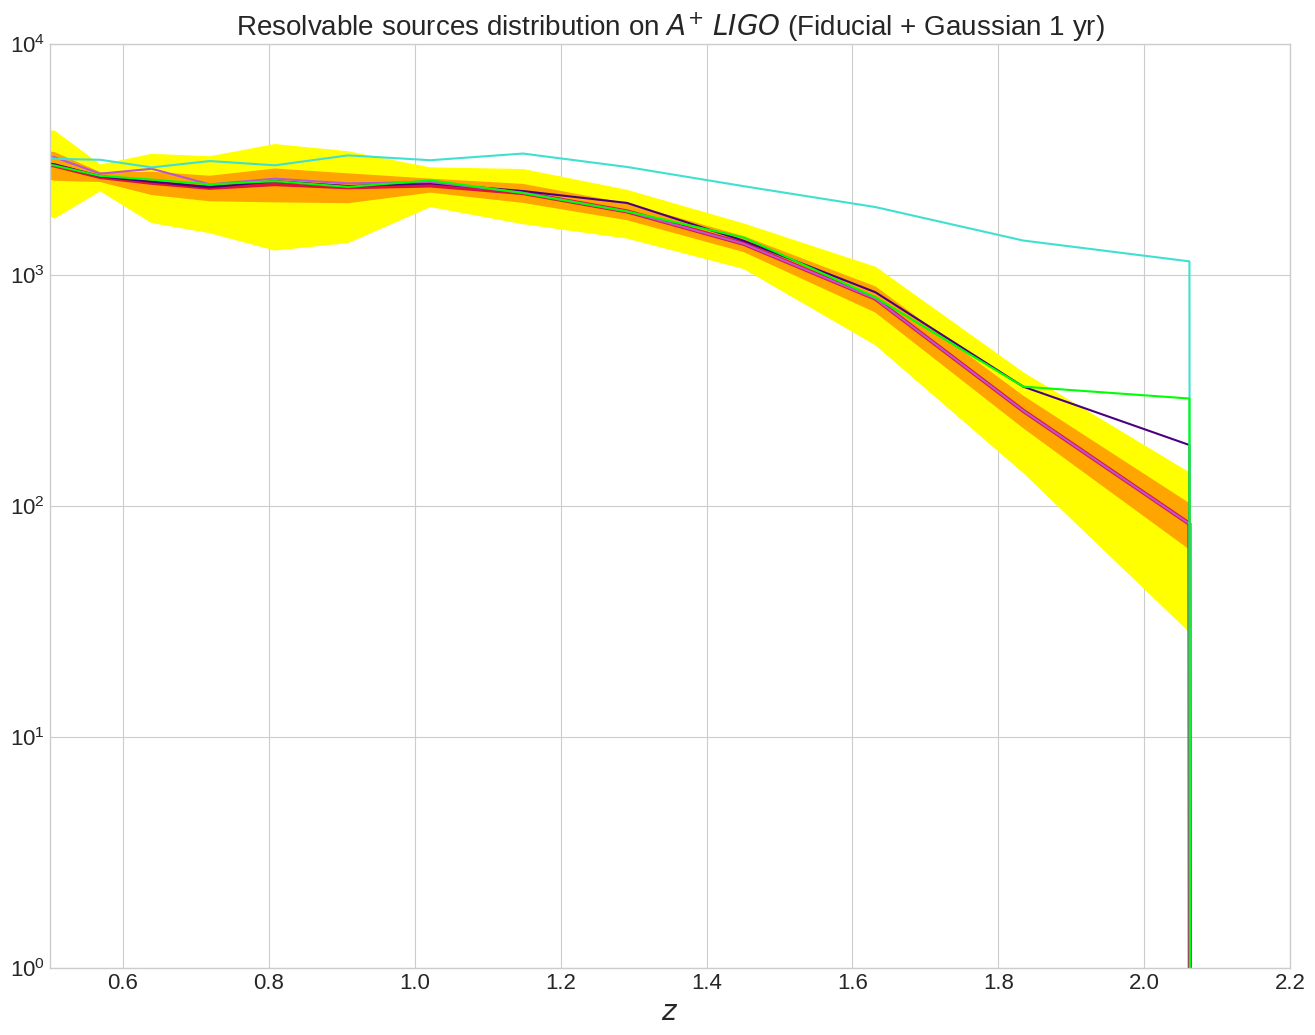

In [37]:
# Plotting the results for the Gaussian subpopulation

plt.figure(figsize=(16,12))
plt.fill_between(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigP3'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigM3'], color = 'yellow', label = r'$3\sigma^{Fid}_{Res}$ region')
plt.fill_between(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigP1'], Fid_Pop['apLIGO_StatAnal']['Red_log']['SigM1'], color = 'orange', label = r'$1\sigma^{Fid}_{Res}$ region')
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'], color = 'crimson', linewidth=3, label = 'Fiducial population average number of resolvable events on $A^+$ LIGO')
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point5']['Red_log']['LIGO_ResEvents'], color = 'Indigo', label = 'Avg + Gaussian Point 5')
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point6']['Red_log']['LIGO_ResEvents'], color = 'mediumorchid', label = 'Avg + Gaussian Point 6')
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point7']['Red_log']['LIGO_ResEvents'], color = 'turquoise', label = 'Avg + Gaussian Point 7')
plt.plot(Fid_Pop['apLIGO_StatAnal']['Red_log']['Redshift'], Fid_Pop['apLIGO_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point8']['Red_log']['LIGO_ResEvents'], color = 'lime', label = 'Avg + Gaussian Point 8')
plt.xlabel('$z$', fontsize = 20 )
plt.xlim(0.5, 2.2)
plt.yscale('log')
plt.ylim(1.e0,1.e4)
#plt.legend(loc = 3, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 16})
#plt.ylabel('# of events with $SNR > 8$', fontsize = 20)
plt.title(r'Resolvable sources distribution on $A^{+} \; LIGO$ (Fiducial + Gaussian 1 yr)',fontsize = 20)
#plt.savefig('apLIGOSNRB8EventDistLogBinPlusGsSubPopNum.png',dpi=200)
plt.savefig('apLIGOSNRB8EventDistLogBinPlusGsSubPopNum.png',dpi=50)

<h2> Plotting the results for ET </h2>

<h3> Plotting the statistic of the fiducial model </h3> 

<h4> Plotting with the logarithmic scale </h4> 

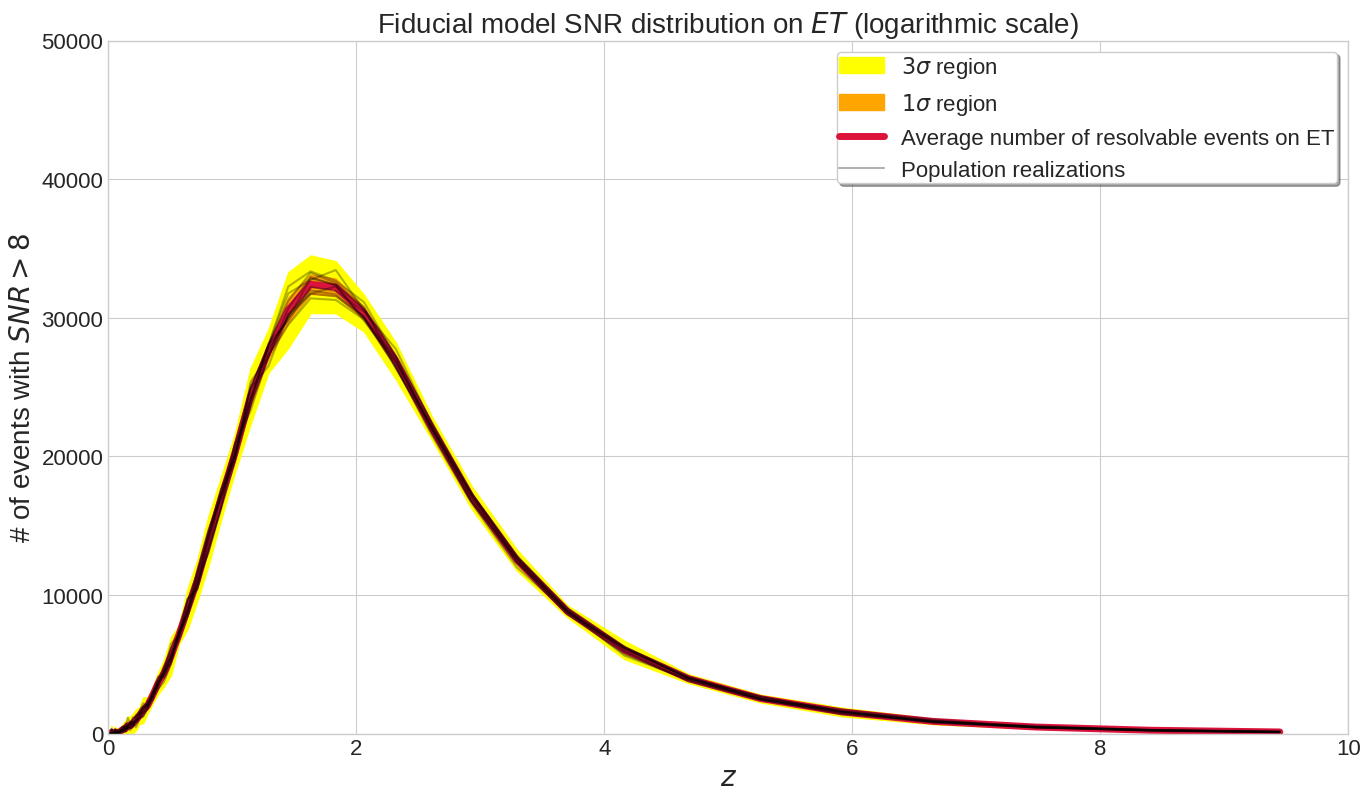

In [38]:
# Plotting the obtained statistics for the fiducial model

plt.figure(figsize=(16,9))
plt.fill_between(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['SigP3'], Fid_Pop['ET_StatAnal']['Red_log']['SigM3'], color = 'yellow', label = r'$3\sigma$ region')
plt.fill_between(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['SigP1'], Fid_Pop['ET_StatAnal']['Red_log']['SigM1'], color = 'orange', label = r'$1\sigma$ region')
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'], color = 'crimson', linewidth=5, label = 'Average number of resolvable events on ET')
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat1']['Red_log']['ET_ResEvents'], color = 'black', alpha = 0.3, label = 'Population realizations')
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat2']['Red_log']['ET_ResEvents'], color = 'black', alpha = 0.3)
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat3']['Red_log']['ET_ResEvents'], color = 'black', alpha = 0.3)
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat4']['Red_log']['ET_ResEvents'], color = 'black', alpha = 0.3)
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat5']['Red_log']['ET_ResEvents'], color = 'black', alpha = 0.3)
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat6']['Red_log']['ET_ResEvents'], color = 'black', alpha = 0.3)
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat7']['Red_log']['ET_ResEvents'], color = 'black', alpha = 0.3)
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat8']['Red_log']['ET_ResEvents'], color = 'black', alpha = 0.3)
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat9']['Red_log']['ET_ResEvents'], color = 'black', alpha = 0.3)
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['Cat10']['Red_log']['ET_ResEvents'], color = 'black', alpha = 0.3)
plt.xlabel('$z$', fontsize = 20 )
plt.xlim(0.0, 10.)
plt.ylim(0.,50000.)
plt.legend(loc = 1, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 16})
plt.ylabel('# of events with $SNR > 8$', fontsize = 20)
plt.title(r'Fiducial model SNR distribution on $ET$ (logarithmic scale)',fontsize = 20)
plt.savefig('ETSNRB8EventDistLogBinFidMod.png',dpi=200)

<h3> Plotting the main plus sub-population on ET </h3>

<h4> Plotting with the logarithmic scale </h4> 

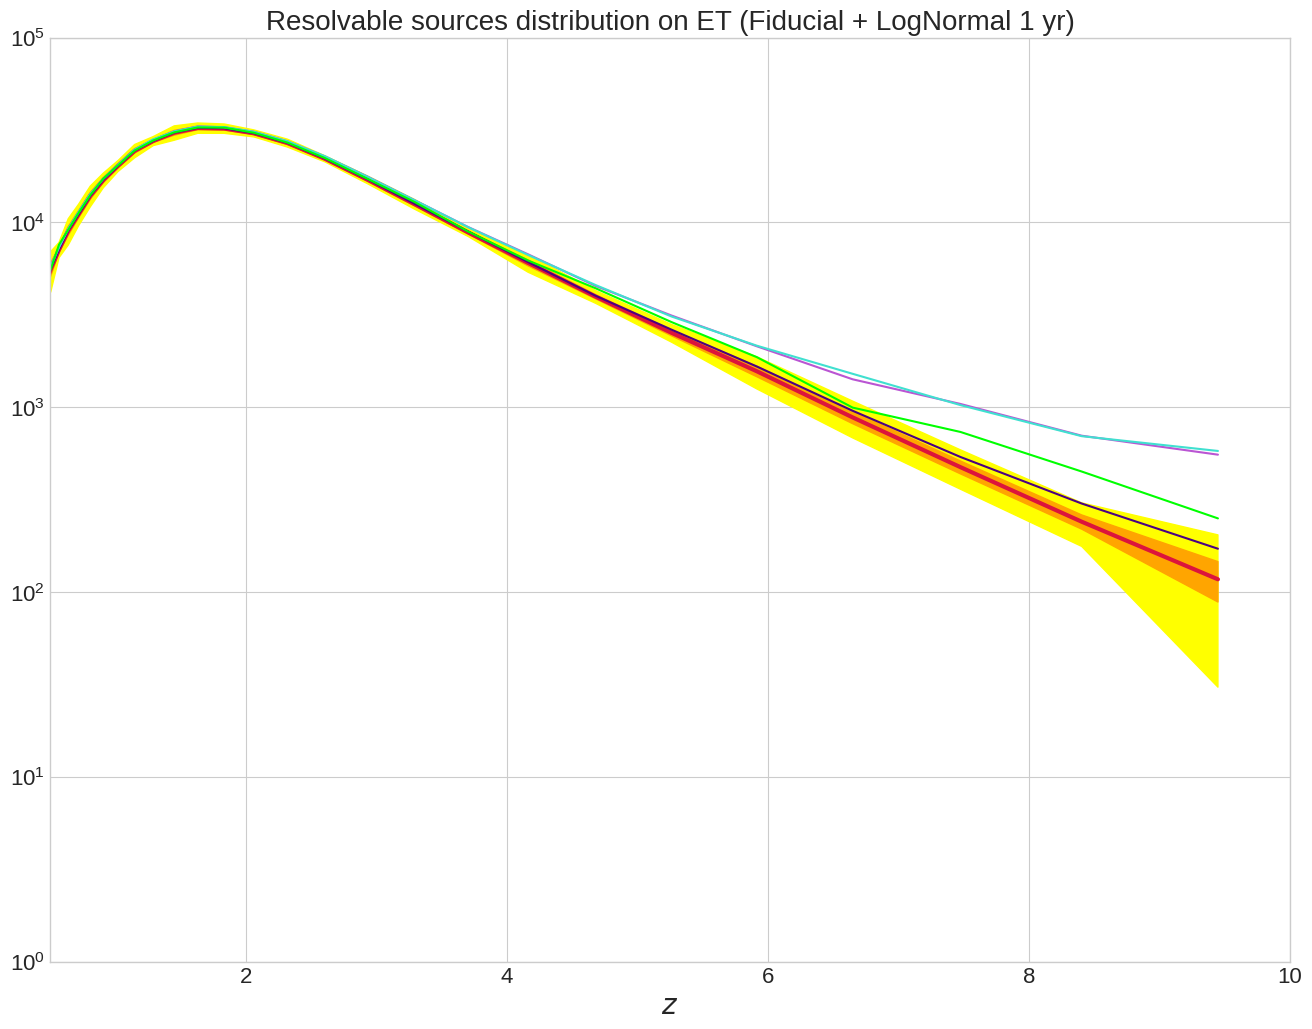

In [39]:
# Plotting the results for the LogNormal subpopulation

plt.figure(figsize=(16,12))
plt.fill_between(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['SigP3'], Fid_Pop['ET_StatAnal']['Red_log']['SigM3'], color = 'yellow', label = r'$3\sigma^{Fid}_{Res}$ region')
plt.fill_between(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['SigP1'], Fid_Pop['ET_StatAnal']['Red_log']['SigM1'], color = 'orange', label = r'$1\sigma^{Fid}_{Res}$ region')
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'], color = 'crimson', linewidth=3, label = 'Fiducial population average number of resolvable events on ET')
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point1']['Red_log']['ET_ResEvents'], color = 'Indigo', label = 'Avg + Log-Normal Point 1')
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point2']['Red_log']['ET_ResEvents'], color = 'mediumorchid', label = 'Avg + Log-Normal Point 2')
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point3']['Red_log']['ET_ResEvents'], color = 'turquoise', label = 'Avg + Log-Normal Point 3')
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point4']['Red_log']['ET_ResEvents'], color = 'lime', label = 'Avg + Log-Normal Point 4')
plt.xlabel('$z$', fontsize = 20 )
plt.xlim(0.5, 10.)
plt.yscale('log')
plt.ylim(1.e0,1.e5)
#plt.legend(loc = 3, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 16})
#plt.ylabel('# of events with $SNR > 8$', fontsize = 20)
plt.title(r'Resolvable sources distribution on ET (Fiducial + LogNormal 1 yr)',fontsize = 20)
#plt.savefig('ETSNRB8EventDistLogBinPlusLNSubPopNum.png',dpi=200)
plt.savefig('ETSNRB8EventDistLogBinPlusLNSubPopNum.png',dpi=50)

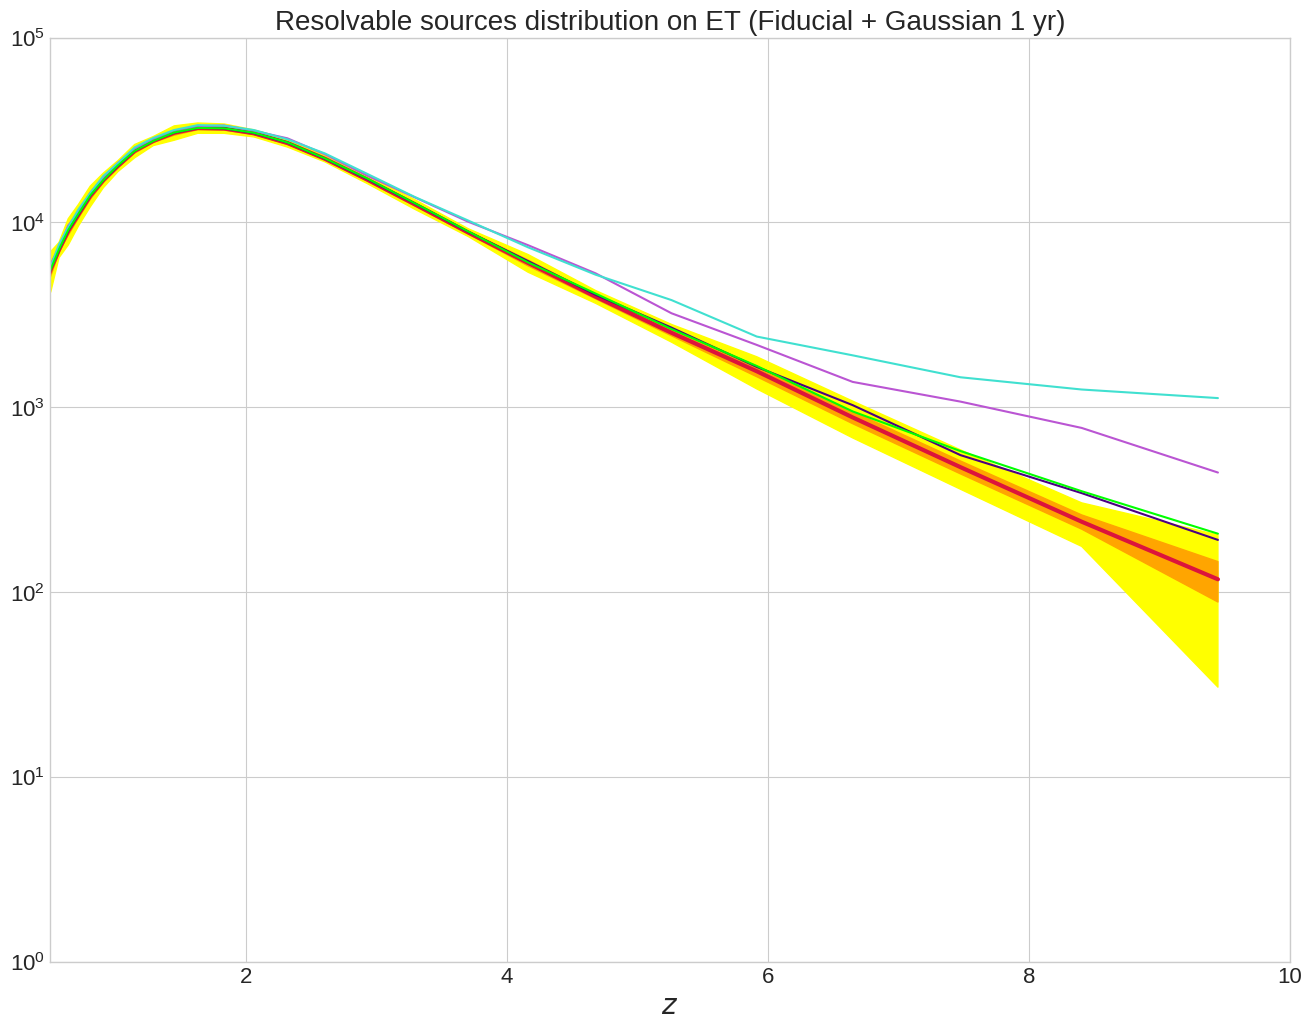

In [40]:
# Plotting the results for the Gaussian subpopulation

plt.figure(figsize=(16,12))
plt.fill_between(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['SigP3'], Fid_Pop['ET_StatAnal']['Red_log']['SigM3'], color = 'yellow', label = r'$3\sigma^{Fid}_{Res}$ region')
plt.fill_between(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['SigP1'], Fid_Pop['ET_StatAnal']['Red_log']['SigM1'], color = 'orange', label = r'$1\sigma^{Fid}_{Res}$ region')
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'], color = 'crimson', linewidth=3, label = 'Fiducial population average number of resolvable events on ET')
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point5']['Red_log']['ET_ResEvents'], color = 'Indigo', label = 'Avg + Gaussian Point 5')
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point6']['Red_log']['ET_ResEvents'], color = 'mediumorchid', label = 'Avg + Gaussian Point 6')
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point7']['Red_log']['ET_ResEvents'], color = 'turquoise', label = 'Avg + Gaussian Point 7')
plt.plot(Fid_Pop['ET_StatAnal']['Red_log']['Redshift'], Fid_Pop['ET_StatAnal']['Red_log']['Avg'] + Sub_Pop['Point8']['Red_log']['ET_ResEvents'], color = 'lime', label = 'Avg + Gaussian Point 8')
plt.xlabel('$z$', fontsize = 20 )
plt.xlim(0.5, 10.)
plt.yscale('log')
plt.ylim(1.e0,1.e5)
#plt.legend(loc = 3, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 16})
#plt.ylabel('# of events with $SNR > 8$', fontsize = 20)
plt.title(r'Resolvable sources distribution on ET (Fiducial + Gaussian 1 yr)',fontsize = 20)
#plt.savefig('ETSNRB8EventDistLogBinPlusGsSubPopNum.png',dpi=200)
plt.savefig('ETSNRB8EventDistLogBinPlusGsSubPopNum.png',dpi=50)